## Assignment 2 : Kaggle
### Facebook Recruiting IV: Human or Robot?

### Abstract

Facebook and kaggle launced a compititon in 2015 to detect the bot activity from an online auction. Human bidders were getting frustrated with the inability to win auctions because of their software controlled opponents. So the objective of this competition is to classify which bids are made by bots and which bids are made by humans. Intially in the training set we had 9 columns giving a brief idea about the auctions. Before building the machine learning model we perfomed feature engineering to help classification model get better picture of the auction. Initially we are using H2O AutoML to test the our predictions and get idea about how our feature engineering resulted. After running the model on H2O we ran the model using normal python libraries. 

We implemeted the following models -
Gradient Boosting machine , Extreme Gradient Boosting, Random forest, Adaptive boosting, Caliberative classifier and Bagging classifier.

**Importing important python libraries**

Required libraries libraries-
* Numpy
* Pandas
* Sci-kit Learn
* XG Boost
* Time

In [2]:
from collections import defaultdict
import os
import time
import numpy as np

import pandas as pd
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, \
    GradientBoostingClassifier, \
    BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import roc_auc_score
import xgboost as xgb

## Dataset:

https://www.kaggle.com/c/facebook-recruiting-iv-human-or-bot/data

We have four data:
1. bids.csv:

    bid_id - The bid id which is unique for each bid given by the bidder 
    
    bidder_id - Unique bidder id for each user who bids in the auction
    
    auction - Each auction has unique id
    
    merchandise - Merchandise for which the bid we was given
    
    device - The phone device which the bidder has given the bid for the auction
    
    time - The CPU time when the bid was given
    
    country - The location of the bidder
    
    ip - The ip address of the bidder
    
    url - The url address of the bid place
    
2. sampleSubmission.csv:

    bidder_id - Unique bidder id for each user who bids in the auction
    
    prediction - Outcome for the prediction if the bidder is bot or human
    
3. test.csv:

    payment_account - Account the bidder is paying for the bid
    
4. train.csv:

    outcome - Prediction score if the bidder is human or robot

### Feature Engineering

We are calculating the time difference between the each bid for that particular auction to denote that robots do not take much of time to keep bidding in the auction as the human thinks before he acts which has very much big time difference in the bidding.

In [4]:
def generate_timediff():
    bids = pd.read_csv('bids.csv')
    bids_grouped = bids.groupby('auction')
    bds = defaultdict(list)
    last_row = None

    for bids_auc in bids_grouped:
        for i, row in bids_auc[1].iterrows():
            if last_row is None:
                last_row = row
                continue

            time_difference = row['time'] - last_row['time']
            bds[row['bidder_id']].append(time_difference)
            last_row = row
            
    df = []
    for key in bds.keys():
        df.append({'bidder_id': key, 'mean': np.mean(bds[key]),
                   'min': np.min(bds[key]), 'max': np.max(bds[key])})
        
    pd.DataFrame(df).to_csv('tdiff.csv', index=False)

In [5]:
def generate_features_auc(group):
    return generate_features(group, auction=True)

We are one-hot encoding the features as most of the features on the dataset are of catagorical data and so we need a dataset of numerical values to train and test the data. 

In [6]:
def generate_features(group, auction=False):
    time_diff = np.ediff1d(group['time'])

    if len(time_diff) == 0:
        diff_mean = 0
        diff_std = 0
        diff_median = 0
        diff_zeros = 0
    else:
        diff_mean = np.mean(time_diff)
        diff_std = np.std(time_diff)
        diff_median = np.median(time_diff)
        diff_zeros = time_diff.shape[0] - np.count_nonzero(time_diff)

    row = dict.fromkeys(categories, 0)
    row.update(dict.fromkeys(countries_list, 0))

    row['devices_c'] = group['device'].unique().shape[0]
    row['countries_c'] = group['country'].unique().shape[0]
    row['ip_c'] = group['ip'].unique().shape[0]
    row['url_c'] = group['url'].unique().shape[0]
    if not auction:
        row['auction_c'] = group['auction'].unique().shape[0]
        row['auc_mean'] = np.mean(group['auction'].value_counts())
    row['merch_c'] = group['merchandise'].unique().shape[0]
    row['bids_c'] = group.shape[0]
    row['tmean'] = diff_mean
    row['tstd'] = diff_std
    row['tmedian'] = diff_median
    row['tzeros'] = diff_zeros

    for cat, value in group['merchandise'].value_counts().iteritems():
        row[cat] = value

    for c in group['country'].unique():
        row[str(c)] = 1

    row = pd.Series(row)
    return row

This is the first function which is called in the program used in grouping the bidder_id and auction so that we can get a grouped data of how the bidder has bid for that particular auction if he continously bidding the auction without much of time differnece.

In [7]:
def group_by_auction():
    bids = pd.read_csv('bids.csv')
    bidders = bids.groupby(['bidder_id', 'auction']). \
        apply(generate_features_auc)
    bidders.to_csv('bids_auc.csv')

We are now transforming the dataframe to vw format to make the process of training and testing the data to have a simple and better performance rate to givea better accuracy.

In [8]:
def df_to_vw(df, categorical, name):
    of = open(name, 'w')
    df.drop(['payment_account', 'address', 'bidder_id'], 1, inplace=True)
    columns = list(df.columns)

    if 'outcome' in columns:
        columns.remove('outcome')

    for i, row in df.iterrows():
        if name == 'train.vw':

            if row['outcome'] == 0:
                outcome = -1
            else:
                outcome = 1

            output = '%s |A ' % outcome
        else:
            output = '-1 |A '

        for column in columns:
            if column in categorical:
                if row[column] == 1:
                    output += '%s_%s ' % (column, 1)
            else:
                output += '%s:%s ' % (column, row[column])
        output += '\n'
        of.write(output)


In [9]:
def to_vw():
    train = pd.read_csv('train_full.csv')
    test = pd.read_csv('test_full.csv')

    if not os.path.exists('vw'):
        os.mkdir('vw')

    # Dirty hack
    categorical = []
    for col in train.columns:
        if len(train[col].unique()) == 2:
            categorical.append(col)

    df_to_vw(train, categorical, name='vw/train.vw')
    df_to_vw(test, categorical, name='vw/test.vw')


We are combing each of the function data to a unique which we save after each functions so that later we can easily train and test the model now it becomes very easy us to get to know more about each bid in the auction by the bidder.

In [10]:
def merge_data():
    t = time.time()
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    bids = pd.read_csv('bids.csv')

    time_differences = pd.read_csv('tdiff.csv', index_col=0)
    bids_auc = pd.read_csv('bids_auc.csv')

    bids_auc = bids_auc.groupby('bidder_id').mean()
    bidders = bids.groupby('bidder_id').apply(generate_features)

    bidders = bidders.merge(bids_auc, right_index=True, left_index=True)
    bidders = bidders.merge(time_differences, right_index=True,
                            left_index=True)

    train = train.merge(bidders, left_on='bidder_id', right_index=True)
    train.to_csv('train_full.csv', index=False)

    test = test.merge(bidders, left_on='bidder_id', right_index=True)
    test.to_csv('test_full.csv', index=False)
    print (time.time() - t)


## Model Designing

To classify the bot and human bids we are designing multiple machine learning models. We are using total 6 classification algorithms.
* Extreme Gradient Boosting
* Random Forest
* Gradient Boosting
* Adaptive Boosting
* Bagging Classifier
* Caliberated Classifier

In [11]:
def xgboost_model(X_train, X_test, y_train):
    X_train = xgb.DMatrix(X_train.values, label=y_train.values)
    X_test = xgb.DMatrix(X_test.values)
    params = {'objective': 'binary:logistic', 'nthread': 10,
              'eval_metric': 'auc', 'silent': 1, 'seed': 1111,
              'max_depth': 6, 'gamma': 0, 'base_score': 0.50,
              'min_child_weight': 4, 'subsample': 0.5,
              'colsample_bytree': 1, 'eta': 0.01,
              }
    model = xgb.train(params, X_train, 600)
    predictions = model.predict(X_test)
    return predictions

In [13]:
def gradient_model(X_train, X_test, y_train):
    model = GradientBoostingClassifier(n_estimators=200,
                                       random_state=1111,
                                       max_depth=5,
                                       learning_rate=0.03,
                                       max_features=40, )
    model.fit(X_train, y_train)
    predictions = model.predict_proba(X_test)[:, 1]
    return predictions

In [14]:
def forest_model(X_train, X_test, y_train):
    model = RandomForestClassifier(n_estimators=160, max_features=35,
                                   max_depth=8, random_state=1111,
                                   criterion='entropy', )
    model.fit(X_train, y_train)
    predictions = model.predict_proba(X_test)[:, 1]
    return predictions


In [15]:
def forest_ada_model(X_train, X_test, y_train):
    model = RandomForestClassifier(n_estimators=160, max_features=35,
                                   max_depth=8, random_state=1111,
                                   criterion='entropy', )
    model = AdaBoostClassifier(base_estimator=model, n_estimators=25)
    model.fit(X_train, y_train)
    predictions = model.predict_proba(X_test)[:, 1]
    return predictions

In [16]:
def forest_calibrated(X_train, X_test, y_train):
    model = RandomForestClassifier(n_estimators=60, max_features=33,
                                   max_depth=8, random_state=1111,
                                   criterion='entropy', )
    model = CalibratedClassifierCV(model, method='isotonic', cv=5)
    model.fit(X_train, y_train)
    predictions = model.predict_proba(X_test)[:, 1]
    return predictions

In [17]:
def forest_bagging(X_train, X_test, y_train):
    model = RandomForestClassifier(n_estimators=150, max_features=40,
                                   max_depth=8, random_state=1111,
                                   criterion='entropy', )
    model = BaggingClassifier(base_estimator=model, max_features=0.80,
                              n_jobs=-1, n_estimators=50)
    model.fit(X_train, y_train)
    predictions = model.predict_proba(X_test)[:, 1]
    return predictions

 As input predict function accepts taining and testing data. The previously designed models are called from the predict function. Every called function returns predictions which are stored in numpy array which is later converted into prediction result.

In [58]:
def predict(X_train, X_test, y_train, g_train, g_test,test_ids, vw=False):
    predictors_len = 6 if vw else 6
    predictions = np.zeros([len(X_test), predictors_len], np.float)
    # predictions[:, 0] = gradient_modelX_train, X_test, y_train)
    # predictions[:, 1] = xgboost_model(X_train, X_test, y_train)
    # predictions[:, 2] = forest_model(X_train, X_test, y_train)
    predictions[:, 0] = gridsearch_gradient(X_train, X_test, y_train)
    predictions[:, 1] = xgboost_random_cv(train,test,ytrain) 
    predictions[:, 2] = gridsearch(X_train, X_test, y_train)
    predictions[:, 3] = forest_ada_model(X_train, X_test, y_train)
    predictions[:, 4] = forest_calibrated(X_train, X_test, y_train)
    predictions[:, 5] = forest_bagging(X_train, X_test, y_train)
    #if vw:
     #   predictions[:, 1] = [float(x.strip()) for x in open(
     #       'vw/preds.txt').readlines()]
    predict_result = pd.DataFrame()
    predict_result['bidder_id'] = test_ids
    predict_result['gradient_model'] = predictions[:,0]
    predict_result['xgboost_model'] = predictions[:,1]
    predict_result['forest_model'] = predictions[:,2]
    # predict_result['graphlab_model'] = predictions[:,3]
    predict_result['forest_ada_model'] = predictions[:,3]
    predict_result['forest_calibrated'] = predictions[:,4]
    predict_result['forest_bagging'] = predictions[:,5]
    
    predict_result.to_csv('prediction_result.csv')

    predictions = np.apply_along_axis(np.mean, axis=1, arr=predictions)
    return predictions


## Hyper-Parameter Tuning

To tune the hyper parameters we are using GridSearch function from sci-kit learn package

In [75]:
from sklearn.model_selection import GridSearchCV
def xgboost_random_cv(X_train, X_test, y_train):
    objective = ['binary:logistic']
    nthread = [5, 10]
    eval_metric= ['auc']
    silent = [1]
    seed = [900,1000,1100]
    max_depth = [int(x) for x in np.linspace(2, 10, num = 5)]
    min_child_weight = [int(x) for x in np.linspace(2, 10, num = 5)]
    eta = [0.03]
    random_grid = {'objective': objective,
               'nthread': nthread,
               'eval_metric': eval_metric,
               'silent': silent,
               'seed': seed,
               'max_depth': max_depth,
               'min_child_weight': min_child_weight,
                  }
    # print(random_grid)
    xgbs = xgb.XGBClassifier()
    Xtrain = xgb.DMatrix(X_train.values, label=y_train.values)
    Xtest = xgb.DMatrix(X_test.values)
    xgboost_cv = GridSearchCV(estimator=xgbs, param_grid= random_grid, cv=2, n_jobs=4)
    xgboost_cv.fit(X_train, y_train)
    print(xgboost_cv.best_params_)
    predictions = xgboost_cv.predict(X_test)
    return predictions

In [74]:
def gridsearch(X_train,X_test,y_train):
    param_grid = { 
    'n_estimators': [140,150,160,170],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [6,7,8,9,10],
    'criterion' :['gini', 'entropy']
    }
    rfc=RandomForestClassifier(random_state=42)
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 2,verbose=1,n_jobs=4)
    CV_rfc.fit(X_train, y_train)
    print(CV_rfc.best_params_)
    predictions = CV_rfc.predict(X_test)
    return predictions

def gridsearch_gradient(X_train,X_test,y_train):
    param_grid = { 
    'n_estimators': [195,205,200,210],
    'max_depth' : [6,7,8,9],
    'max_features':['auto','sqrt']
    }
    grad=GradientBoostingClassifier(random_state=111)
    CV_grad = GridSearchCV(estimator=grad, param_grid=param_grid, cv= 2,verbose=1,n_jobs=4)
    CV_grad.fit(X_train, y_train)
    print(CV_grad.best_params_)
    predictions = CV_grad.predict(X_test)
    return predictions

### Handling Null Values before final submission

The sample sumbission file contains all the bids required to be classified. There are nearly 4700 bids in the submission file. However there are some missing values also which needs to be taken care of before submitting the file.

We are filling the all the null values with mean and converting it to csv format for submission.

In [60]:
def submit(X_train, X_test, y_train, gtrain, gtest, test_ids):
    predictions = predict(X_train, X_test, y_train, gtrain, gtest, test_ids, vw=True)

    sub = pd.read_csv('sampleSubmission.csv')
    result = pd.DataFrame()
    result['bidder_id'] = test_ids
    result['outcome'] = predictions
    sub = sub.merge(result, on='bidder_id', how='left')

    # Fill missing values with mean
    sub.fillna(0.0511674, inplace=True)

    sub.drop('prediction', 1, inplace=True)
    sub.to_csv('result.csv', index=False, header=['bidder_id', 'prediction'])

In [76]:
if __name__ == "__main__":
    if not os.path.exists('train_full.csv'):
        
        group_by_auction()
        generate_timediff()
        merge_data()
        to_vw()

    train = pd.read_csv('train_full.csv')
    test = pd.read_csv('test_full.csv')
    train['outcome'] = train['outcome'].astype(int)

    gtrain = train.copy()
    gtest = test.copy()

    ytrain = train['outcome']

    train.drop('outcome', 1, inplace=True)
    test_ids = test['bidder_id']

    labels = ['payment_account', 'address', 'bidder_id']
    train.drop(labels=labels, axis=1, inplace=True)
    test.drop(labels=labels, axis=1, inplace=True)

    submit(train, test, ytrain, gtrain, gtest, test_ids)

Fitting 2 folds for each of 32 candidates, totalling 64 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  64 out of  64 | elapsed:  1.7min finished


{'max_features': 'sqrt', 'n_estimators': 195, 'max_depth': 9}
{'silent': 1, 'eval_metric': 'auc', 'nthread': 5, 'min_child_weight': 2, 'seed': 900, 'objective': 'binary:logistic', 'max_depth': 10}
Fitting 2 folds for each of 120 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   27.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:  2.5min finished


{'max_features': 'auto', 'n_estimators': 140, 'criterion': 'gini', 'max_depth': 9}


## Conclusion

We trained and designed multiple machine learning models. The main objective of the challenge was to classify whether the bidder is a human or bot. The feature engineering improved the performance of all models. We trained models with and without hyperparameter tuning. After hyper parameter tuning the model imporved even better. For our base model was a XGBoost of 15 iterations to get an AUC of 0.938 and on private leaderboard it places us on 15th position. So to improve the AUC we tuned the hyper parameters of various models as a ensemble of models, after hyperparameter tuning the best AUC we are getting is 0.9388 and on private leaderboard we stand at 12th position.

## Leaderboard:

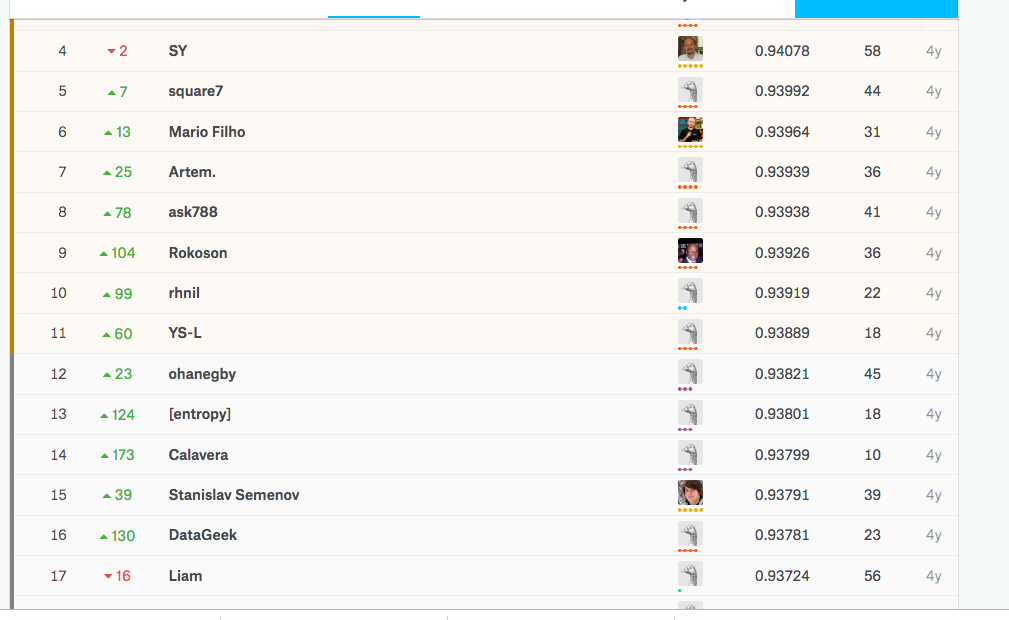

## Submission:

/bin/sh: -c: line 0: syntax error near unexpected token `attachment:image.png'
/bin/sh: -c: line 0: `[image.png](attachment:image.png)'


## Citations

The program we have referred to build about the assignment is mentioned below.

1. https://github.com/wallinm1/kaggle-facebook-bot/blob/master/facebook_notebook.ipynb

We referred this notebook to check the insights of the other competitors have approached the problem and we understood more about the feature engineering from the below links helped us to apporoach the problem in a better way.

2. https://github.com/rushter/Facebook-Recruiting/blob/master/main.py
3. http://www.thomas-robert.fr/en/kaggles-human-or-robot-competition-feedback/

We have used grid search algorthim from the below links to find the best hyperparameters to be used predict the testing data and to see if there is an increase in the accuracy.

4. https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/


## Contribution:

The kaggle assignment for Facebook "Human or Robot" Competition was referenced (1) and we made modifications to the features by the feature engineering (2) (3). First the algorithm was a XGBoost which was iterated 15 times to give an accuracy of 93.8% and we changed the program as a ensemble of the models (Extreme Grdient Boosting, Random Forest Classifier, Gradient Boosting, Calibrated Boosting, Adaptive Boosting Classifier, Random Forest Bagging Classifier) to get better accuracy of 93.82%. Afterwards we trained the dataset to the H2O as instructed in the separate notebooka and for the implementations for the H2O please refer the H2O notebook. We wanted to check if we have fed the model with the right parameters so we checked using the grid search with list of hyperparameters to each model giving us an increase of 93.88 accuracy. This made us understand that the hyperparameters for each model was different from the first time and when we ran the model with grid search having giving even better hyper parameters. 

## License :

Copyright (c) 2019 Johail Sherieff, Parag Bhingarkar

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.